# This notebook is simply used for modelling data

For the sake of simplicty, this notebook contains the following
- Processing of necessary data
- Using the given data to create a simple linear regression model for prediction

In [49]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from elasticsearch import Elasticsearch
import plotly.express as px


## Data processing

The below data will be used for this model:

### Response variable: Regional population dataset

- This dataset contains the population related information in Victoria, ranging from births, deaths to migration.
- The key feature that we're interested in is the erp_YYYY column, which holds the estimated regional population for Melbourne



In [ ]:

INDEX_NAME = "abs-regional_population_lga_2001-2021"

es_client = Elasticsearch (
        'https://localhost:9200',
        verify_certs= False,
        ssl_show_warn= False,
        basic_auth=('elastic', 'elastic')
    )
es_client.indices.refresh(index=INDEX_NAME)
result = es_client.search(index=INDEX_NAME, body = {
'size' : 1000,
'query': {
    'match_all' : {}
}
})


es_data = []
for doc in result['hits']['hits']:
    es_data.append(doc['_source'])
response = pd.DataFrame(es_data)




In [4]:
response.head()

,births_2017_18,natural_increase_2020_21,births_2020_21,births_2016_17,state_name_2021,net_internal_migration_2019_20,deaths_2018_19,internal_departures_2018_19,natural_increase_2018_19,overseas_departures_2018_19,...,erp_2001,erp_2003,erp_2002,erp_2005,erp_2004,internal_arrivals_2020_21,internal_arrivals_2018_19,net_overseas_migration_2017_18,natural_increase_2019_20,births_2018_19
0,1414,210,1200,1529,Victoria,-2134,1050,13913,351,4399,...,156246,157298,156886,158727,157885,12782,12966,2471,229,1401
1,1673,642,1568,1852,Victoria,-977,935,12156,723,3133,...,122346,123816,123197,126485,125037,11915,11285,2849,671,1658
2,1421,381,1196,1479,Victoria,-427,761,9636,614,1360,...,104793,104629,104856,105059,104632,9278,9667,1782,561,1375
3,2562,1016,2184,2505,Victoria,-1009,1132,15747,1363,3129,...,135540,136630,136156,138963,137642,15245,14822,3616,1309,2495
4,1313,594,1069,1330,Victoria,-1439,479,12095,757,3358,...,80054,84170,82220,87831,86017,11523,11491,2253,697,1236


### Predictor variable: Buildling permits dataset

- This dataset contains information about building permits in Melbourne

In [ ]:
INDEX_NAME = "building-permits"

es_client = Elasticsearch (
        'https://localhost:9200',
        verify_certs= False,
        ssl_show_warn= False,
        basic_auth=('elastic', 'elastic')
    )
es_client.indices.refresh(index=INDEX_NAME)

count = 0
es_data = []
try:
    while True:
        result = es_client.search(index=INDEX_NAME, body = {"from": count
                                                            ,'size' : 100,
        'query': {
            'match_all' : {}
        }
        }
        )
        for doc in result['hits']['hits']:
            es_data.append(doc['_source'])
        count += 100
except:
    print("Got all the Documents")

predictor = pd.DataFrame(es_data)

In [6]:
predictor.head()

,council_ref,permit_number,issue_date,address,desc_of_works,estimated_cost_of_works,rbs_number,commence_by_date,completed_by_date,permit_certificate_type
0,BP-2022-1259,9042530389216,2022-08-22,299-307 Bourke Street MELBOURNE VIC 3000,Alteration and extension,5280000,None,2023-08-22,2025-08-22,Building Permit
1,BP-2022-1253,54182/4621763091106/1,2022-12-19,633-669 Flinders Street DOCKLANDS VIC 3008,Level 4 - Internal Office Fitout for Artifex P...,4937932,BS-U 42327,2023-08-12,2025-08-12,Certificate of Final Inspection
2,BP-2022-1253,54182/4621763091106/1,2022-08-12,18-38 Siddeley Street DOCKLANDS VIC 3008,Level 4 - Internal Office Fitout for Artifex P...,4937932,BS-U 42327,2023-08-12,2025-08-12,Building Permit
3,BP-2022-1251,54182/2724469366956/0A,2022-08-12,Rialto 505-535 Collins Street MELBOURNE VIC 3000,Level 30 - Internal Tenancy Split and Internal...,610967,None,2023-08-12,2025-08-12,Building Permit
4,BP-2022-1249,54182/1861978441258/0,2022-08-05,816-828 Bourke Street DOCKLANDS VIC 3008,Level 6 - Internal Office Fitout for AFG,847172,BS-U 42327,2023-08-05,2025-08-05,Building Permit


First, we have a quick look at the response dataset we've loaded

In [7]:
response.columns

Index(['births_2017_18', ' natural_increase_2020_21', ' births_2020_21',
       ' births_2016_17', ' state_name_2021',
       ' net_internal_migration_2019_20', ' deaths_2018_19',
       ' internal_departures_2018_19', ' natural_increase_2018_19',
       ' overseas_departures_2018_19', ' natural_increase_2017_18',
       ' overseas_departures_2017_18', ' lga_name_2021',
       ' internal_arrivals_2017_18', ' overseas_departures_2020_21',
       ' deaths_2017_18', ' internal_arrivals_2016_17', ' lga_code_2021',
       ' net_overseas_migration_2019_20', ' internal_departures_2016_17',
       ' deaths_2016_17', ' erp_2017', ' erp_2018', ' erp_2019',
       ' net_internal_migration_2017_18', ' erp_2021', ' erp_2020',
       ' erp_change_per_cent_2020_21', ' net_overseas_migration_2016_17',
       ' overseas_arrivals_2020_21', ' net_internal_migration_2018_19',
       ' overseas_arrivals_2016_17', ' net_overseas_migration_2018_19',
       ' overseas_arrivals_2017_18', ' area_km2',
       ' 

Here, despite the wide range of information, we only need the estimated population data (erp_YYYY) for our model. Further, notice the random spacing before each column name, asides from the first.

In [8]:
# Remove spacing from column names

response.columns = response.columns.str.replace(' ', '')

In [9]:
# Get all key columns for our response dataset. The years range from 2001 to 2021, inclusive of start & end. 

KEY_RESPONSE_COLUMNS = ['lga_name_2021']

for i in range(2001, 2022):
    key_column = f"erp_{i}"
    KEY_RESPONSE_COLUMNS.append(key_column)

In [10]:
response[KEY_RESPONSE_COLUMNS]

,lga_name_2021,erp_2001,erp_2002,erp_2003,erp_2004,erp_2005,erp_2006,erp_2007,erp_2008,erp_2009,...,erp_2012,erp_2013,erp_2014,erp_2015,erp_2016,erp_2017,erp_2018,erp_2019,erp_2020,erp_2021
0,Boroondara,156246,156886,157298,157885,158727,159605,161308,163408,165284,...,168483,170485,172660,174753,177276,179677,181376,183197,182974,176632
1,Glen Eira,122346,123197,123816,125037,126485,128474,130524,132900,135414,...,139116,141260,143694,145924,148583,151457,153920,156535,158149,155123
2,Moonee Valley,104793,104856,104629,104632,105059,105717,106716,108417,110367,...,113673,115464,117763,120231,122871,125411,127906,130313,131702,129379
3,Moreland,135540,136156,136630,137642,138963,140872,143694,146450,150114,...,156967,160282,164099,167870,172294,176974,181780,185811,188660,184707
4,Port Phillip,80054,82220,84170,86017,87831,89641,91490,93174,95272,...,99893,102156,104451,106381,108627,110656,113265,115620,116417,112092
5,Yarra,68522,69415,70115,70811,71719,72808,74289,75868,77311,...,81268,83962,87228,89923,92894,95994,98567,101516,103076,99622
6,Bayside (Vic.),88262,88717,89088,89394,89873,90807,92041,93535,94850,...,96971,98252,99797,101268,102912,104282,105745,106856,107516,105580
7,Hobsons Bay,82854,83124,83107,82668,82990,83906,84819,85513,86767,...,88339,89188,90417,91674,93445,95071,96481,97765,98146,96317
8,Stonnington,89424,90370,91034,92061,92893,94056,95228,96841,98186,...,101410,103487,105894,108028,111003,113772,116281,117776,118567,114340
9,Unincorporated Vic,451,516,578,638,697,757,741,745,749,...,797,808,835,862,892,899,889,881,894,910


Now, we separate this dataframe into a format we're able to use

In [11]:
# Pick out row 7 to turn into dataframe

response_clean = pd.DataFrame(response[KEY_RESPONSE_COLUMNS].iloc[7]).reset_index()

In [12]:
# Rename and clean columns

response_clean = response_clean.rename(columns={'index': 'year', 7: 'population'})
response_clean = response_clean.iloc[1:] # Remove unnceessary row
response_clean['year'] = response_clean['year'].str.removeprefix('erp_')
response_clean['year'] = response_clean['year'].astype(int)

Now we move onto our predictor dataset to have a quick look

In [13]:
len(predictor)

63638

adding a new column called year based on issue date for better analysis 

In [26]:
predictor['issue_date'] = pd.to_datetime(predictor['issue_date'])
predictor['year'] = predictor['issue_date'].dt.year

In [27]:
predictor.columns

Index(['council_ref', 'permit_number', 'issue_date', 'address',
       'desc_of_works', 'estimated_cost_of_works', 'rbs_number',
       'commence_by_date', 'completed_by_date', 'permit_certificate_type',
       'year'],
      dtype='object')

Note that this dataset has gotten an initial clean, removing records where:
- issue_date > completed_by_date
- Year is in the future

However, there seems to be records of duplicate permits (same coucil_ref). We observe more closely

In [28]:
predictor_count = predictor.groupby(['council_ref'])['permit_number'].count().sort_values(ascending=False).reset_index(name='count')
predictor_count[predictor_count['count'] > 1]

,council_ref,count
0,BP-2019-1273,66
1,BP-2020-1544,56
2,BP-2020-460/4,42
3,BP-2018-2091,36
4,BP-2019-1273/1,33
...,...,...
19332,BP-2017-149,2
19333,BP-2017-1429,2
19334,BP-2016-969,2
19335,BP-2017-1213,2


Here, observe a few highest values and see why it's been duplicated

In [29]:
predictor[predictor['council_ref'] == 'BP-2019-1273']

,council_ref,permit_number,issue_date,address,desc_of_works,estimated_cost_of_works,rbs_number,commence_by_date,completed_by_date,permit_certificate_type,year
5218,BP-2019-1273,1585/20190205/1A,2019-05-28,Part Level 5 276 Flinders Street MELBOURNE VIC...,Proposed Fitout of Levels 5-9 for the Purpose ...,2922588,None,2020-05-28,2022-05-28,Building Permit,2019
6723,BP-2019-1273,1585/20190205/0,2019-10-01,Level 7 276 Flinders Street MELBOURNE VIC 3000,Proposed Fitout of Levels 5-9 for the Purpose ...,2922588,None,2020-05-28,2022-05-28,Certificate of Final Inspection,2019
6724,BP-2019-1273,1585/20190205/0,2019-07-15,Part Level 6 276 Flinders Street MELBOURNE VIC...,Proposed Fitout of Levels 5-9 for the Purpose ...,2922588,None,2020-05-28,2022-05-28,Certificate of Final Inspection,2019
6725,BP-2019-1273,1585/20190205/0,2019-07-15,Level 5 276 Flinders Street MELBOURNE VIC 3000,Proposed Fitout of Levels 5-9 for the Purpose ...,2922588,None,2020-05-28,2022-05-28,Certificate of Final Inspection,2019
6726,BP-2019-1273,1585/20190205/1A,2019-10-01,Part Level 8 276 Flinders Street MELBOURNE VIC...,Proposed Fitout of Levels 5-9 for the Purpose ...,2922588,None,2020-05-28,2022-05-28,Certificate of Final Inspection,2019
...,...,...,...,...,...,...,...,...,...,...,...
58419,BP-2019-1273,1585/20190205/0,2019-05-28,Part Level 6 276 Flinders Street MELBOURNE VIC...,Proposed Fitout of Levels 5-9 for the Purpose ...,2922588,None,2020-05-28,2022-05-28,Building Permit,2019
58420,BP-2019-1273,1585/20190205/0,2019-05-28,Level 7 276 Flinders Street MELBOURNE VIC 3000,Proposed Fitout of Levels 5-9 for the Purpose ...,2922588,None,2020-05-28,2022-05-28,Building Permit,2019
58421,BP-2019-1273,1585/20190205/1A,2019-10-01,Part Level 7 276 Flinders Street MELBOURNE VIC...,Proposed Fitout of Levels 5-9 for the Purpose ...,2922588,None,2020-05-28,2022-05-28,Certificate of Final Inspection,2019
58422,BP-2019-1273,1585/20190205/1A,2019-10-01,Part Level 6 276 Flinders Street MELBOURNE VIC...,Proposed Fitout of Levels 5-9 for the Purpose ...,2922588,None,2020-05-28,2022-05-28,Certificate of Final Inspection,2019


In [30]:
predictor[predictor['council_ref'] == 'BP-2020-1544']

,council_ref,permit_number,issue_date,address,desc_of_works,estimated_cost_of_works,rbs_number,commence_by_date,completed_by_date,permit_certificate_type,year
1802,BP-2020-1544,58176/7362369321433/0,2020-08-04,Unit 2202 Level 22 38 Rose Lane MELBOURNE VIC ...,"Lots 1909, 2002, 2009, 2102, 2104 2109, 2110, ...",487857,BS-15013,2021-08-04,2022-08-04,Building Permit,2020
1803,BP-2020-1544,7362369321433/A,2020-08-04,Unit 2409 Level 24 38 Rose Lane MELBOURNE VIC ...,"Lots 1909, 2002, 2009, 2102, 2104 2109, 2110, ...",487857,BS-15013,2021-08-04,2022-08-04,Building Permit,2020
1804,BP-2020-1544,7362369321433/A,2021-02-16,Unit 1909 Level 19 38 Rose Lane MELBOURNE VIC ...,"Lots 1909, 2002, 2009, 2102, 2104 2109, 2110, ...",487857,BS-15013,2021-08-04,2022-08-04,Certificate of Final Inspection,2021
1805,BP-2020-1544,7362369321433/A,2021-02-16,Unit 2002 Level 20 38 Rose Lane MELBOURNE VIC ...,"Lots 1909, 2002, 2009, 2102, 2104 2109, 2110, ...",487857,BS-15013,2021-08-04,2022-08-04,Certificate of Final Inspection,2021
1806,BP-2020-1544,7362369321433/A,2021-02-16,Unit 2102 Level 21 38 Rose Lane MELBOURNE VIC ...,"Lots 1909, 2002, 2009, 2102, 2104 2109, 2110, ...",487857,BS-15013,2021-08-04,2022-08-04,Certificate of Final Inspection,2021
1807,BP-2020-1544,58176/7362369321433/0,2021-02-16,Unit 1909 Level 19 38 Rose Lane MELBOURNE VIC ...,"Lots 1909, 2002, 2009, 2102, 2104 2109, 2110, ...",487857,BS-15013,2021-08-04,2022-08-04,Certificate of Final Inspection,2021
7221,BP-2020-1544,58176/7362369321433/0,2020-08-04,Unit 2209 Level 22 38 Rose Lane MELBOURNE VIC ...,"Lots 1909, 2002, 2009, 2102, 2104 2109, 2110, ...",487857,BS-15013,2021-08-04,2022-08-04,Building Permit,2020
7222,BP-2020-1544,7362369321433/A,2020-08-04,Unit 2104 Level 21 38 Rose Lane MELBOURNE VIC ...,"Lots 1909, 2002, 2009, 2102, 2104 2109, 2110, ...",487857,BS-15013,2021-08-04,2022-08-04,Building Permit,2020
16788,BP-2020-1544,58176/7362369321433/0,2020-08-04,Unit 2509 Level 25 38 Rose Lane MELBOURNE VIC ...,"Lots 1909, 2002, 2009, 2102, 2104 2109, 2110, ...",487857,BS-15013,2021-08-04,2022-08-04,Building Permit,2020
16789,BP-2020-1544,7362369321433/A,2021-02-16,Unit 2509 Level 25 38 Rose Lane MELBOURNE VIC ...,"Lots 1909, 2002, 2009, 2102, 2104 2109, 2110, ...",487857,BS-15013,2021-08-04,2022-08-04,Certificate of Final Inspection,2021


In [31]:
predictor[predictor['council_ref'] == 'BP-2016-2421']

,council_ref,permit_number,issue_date,address,desc_of_works,estimated_cost_of_works,rbs_number,commence_by_date,completed_by_date,permit_certificate_type,year
3133,BP-2016-2421,2622020160057/0,2016-11-03,269-321 Lonsdale Street MELBOURNE VIC 3000,(LG-26) Tenancy fitout of Shop (6c) - Fleet St...,45000,None,2017-11-03,2019-11-03,Building Permit,2016
32422,BP-2016-2421,2622020160057/0,2016-11-03,Shop 26 LwrGround 287 Lonsdale Street MELBOURN...,(LG-26) Tenancy fitout of Shop (6c) - Fleet St...,45000,None,2017-11-03,2019-11-03,Building Permit,2016


In [32]:
set(predictor['permit_certificate_type'])

{'Building Permit',
 'Certificate of Final Inspection',
 'Certificate of Occupancy',
 'Occupancy Permit'}

Appears that for a single building, a building permit has to be given out for each room that will be going under construction, given that the building is an apartment. Further, there seems to be overlapping records if the location has multiple options of displaying the address (lower ground, level, unit, etc.). Thus, to reduce a single apartment having too much leverage on the model, we should drop duplicates by permit_number. 

Only keeping 1 record per permit number will resolve the following:
- Slightly differing addresses causing multiple records
- Removal of same apartment having multiple records per building work due to it impacting multiple rooms/units
- It will keep the difference between building permit, certificate of final inspection, and so on. This will give points for more active buildings which have their construction complete


In [33]:
# Remove duplicate permit numbers

predictor_clean = predictor.drop_duplicates(subset=['permit_number'])
len(predictor_clean)

31004

In [34]:
predictor_clean.head()

,council_ref,permit_number,issue_date,address,desc_of_works,estimated_cost_of_works,rbs_number,commence_by_date,completed_by_date,permit_certificate_type,year
0,BP-2022-1259,9042530389216,2022-08-22,299-307 Bourke Street MELBOURNE VIC 3000,Alteration and extension,5280000,None,2023-08-22,2025-08-22,Building Permit,2022
1,BP-2022-1253,54182/4621763091106/1,2022-12-19,633-669 Flinders Street DOCKLANDS VIC 3008,Level 4 - Internal Office Fitout for Artifex P...,4937932,BS-U 42327,2023-08-12,2025-08-12,Certificate of Final Inspection,2022
3,BP-2022-1251,54182/2724469366956/0A,2022-08-12,Rialto 505-535 Collins Street MELBOURNE VIC 3000,Level 30 - Internal Tenancy Split and Internal...,610967,None,2023-08-12,2025-08-12,Building Permit,2022
4,BP-2022-1249,54182/1861978441258/0,2022-08-05,816-828 Bourke Street DOCKLANDS VIC 3008,Level 6 - Internal Office Fitout for AFG,847172,BS-U 42327,2023-08-05,2025-08-05,Building Permit,2022
5,BP-2022-1247,3542543973820/1,2022-09-07,195 Swanston Street MELBOURNE VIC 3000,Internal Tenancy Fitout for Soul Café\r(Stage ...,187832,None,2023-09-07,2025-09-07,Building Permit,2022


It appears that we have have roughly removed half the records by doing so. Now, we group the dataset by year so that we can get a dataset we can use in our model

In [35]:
predictor_clean = predictor_clean.groupby('year')['council_ref'].count().reset_index(name='count')

Note that our response dataset only has data between 2001 ~ 2021. We remove the year 2000, but 2022 ~ 2024 can be used as the model's performance indicator :D

In [36]:
predictor_clean = predictor_clean[predictor_clean['year'] > 2000]

In [37]:
predictor_clean = predictor_clean.rename(columns={'count': 'building_permit_count'})

Now that we've finalised processing both datasets, we join them

In [38]:
analysis_df = pd.merge(predictor_clean, response_clean, on='year')
analysis_df['year'] = pd.to_numeric(analysis_df['year'])
analysis_df['building_permit_count'] = pd.to_numeric(analysis_df['building_permit_count'])
analysis_df['population'] = pd.to_numeric(analysis_df['population'])


In [39]:
# Calculate and display correlation
correlation = analysis_df['building_permit_count'].corr(analysis_df['population'])
print(f"Correlation between building permit count and population: {correlation:.2f}")



Correlation between building permit count and population: 0.88


This calculates the Pearson correlation coefficient between building_permit_count and population and prints it.The correlation coefficient of 0.87 indicates a strong positive correlation between building permit counts and population. This means that as the number of building permits increases, the population also tends to increase.

In [40]:
partial_model = ols(
    formula='population ~ building_permit_count',
    data=analysis_df
).fit()

print(partial_model.summary())

                            OLS Regression Results                            
Dep. Variable:             population   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     64.00
Date:                Mon, 20 May 2024   Prob (F-statistic):           1.68e-07
Time:                        01:19:22   Log-Likelihood:                -194.33
No. Observations:                  21   AIC:                             392.7
Df Residuals:                      19   BIC:                             394.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              8.532e+

In [41]:
full_model = ols(
    formula='population ~ building_permit_count + year',
    data=analysis_df
).fit()

print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:             population   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     246.9
Date:                Mon, 20 May 2024   Prob (F-statistic):           8.24e-14
Time:                        01:19:24   Log-Likelihood:                -174.66
No. Observations:                  21   AIC:                             355.3
Df Residuals:                      18   BIC:                             358.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.248e+

It appears that adding the year as a variable after having building permit counts is still statistically significant. We also test for interaction

In [42]:
interaction_model = ols(
    formula='population ~ building_permit_count + year + building_permit_count*year',
    data=analysis_df
).fit()

print(interaction_model.summary())

                            OLS Regression Results                            
Dep. Variable:             population   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     291.3
Date:                Mon, 20 May 2024   Prob (F-statistic):           8.26e-15
Time:                        01:19:32   Log-Likelihood:                -168.24
No. Observations:                  21   AIC:                             344.5
Df Residuals:                      17   BIC:                             348.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Interaction also seems to be significant, even with the other 2 features already being added to the model. Test for goodness of fit

In [43]:
interaction_model.aic < full_model.aic

True

In [44]:
anova_lm(interaction_model)

,df,sum_sq,mean_sq,F,PR(>F)
building_permit_count,1.0,4.516401e+08,4.516401e+08,686.984806,3.464213e-15
year,1.0,1.134854e+08,1.134854e+08,172.621367,2.484719e-10
building_permit_count:year,1.0,9.426549e+06,9.426549e+06,14.338621,1.472965e-03
Residual,17.0,1.117620e+07,6.574237e+05,NaN,NaN


Attempt to predict 2022, 2023 and 2024 population

In [45]:
predict_df = predictor_clean.iloc[21:]

In [46]:
interaction_model.predict(predict_df)

22     99794.642330
23    100857.516540
24     96387.600771
dtype: float64

Round the numbers to the nearest whole. Thus, our final conclusion can be:

### 2022

194064 people

### 2023

201739 people

### 2024

175977 people

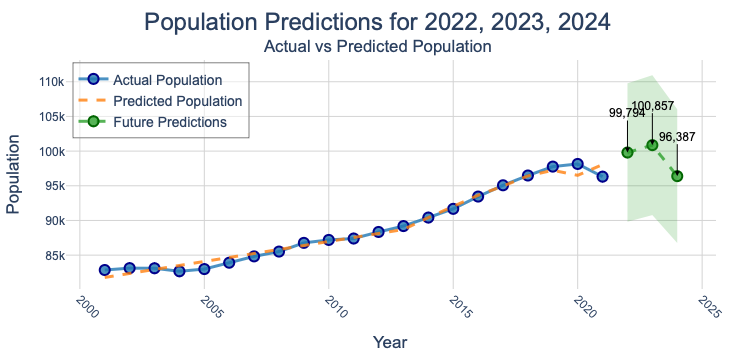

In [50]:

future_predictions = interaction_model.predict(predict_df)
# Future Predictions
years = [2022, 2023, 2024]
future_populations = future_predictions.values


# Create traces
actual_trace = go.Scatter(
    x=analysis_df['year'],
    y=analysis_df['population'],
    mode='markers+lines',
    name='Actual Population',
    marker=dict(color='rgba(31, 119, 180, 0.8)', size=10, line=dict(width=2, color='darkblue')),
    line=dict(width=3, color='rgba(31, 119, 180, 0.8)')
)
predicted_trace = go.Scatter(
    x=analysis_df['year'],
    y=interaction_model.fittedvalues if interaction_model else analysis_df['population'],  # Simulated for demo
    mode='lines',
    name='Predicted Population',
    line=dict(dash='dash', color='rgba(255, 127, 14, 0.8)', width=3)
)
future_trace = go.Scatter(
    x=years,
    y=future_populations,
    mode='markers+lines',
    name='Future Predictions',
    line=dict(dash='dash', color='rgba(44, 160, 44, 0.8)', width=3),
    marker=dict(color='rgba(44, 160, 44, 0.8)', size=10, line=dict(width=2, color='darkgreen'))
)

# Create figure
fig = make_subplots()
fig.add_trace(actual_trace)
fig.add_trace(predicted_trace)
fig.add_trace(future_trace)

# Add shaded area for prediction range
fig.add_trace(go.Scatter(
    x=years + years[::-1],  # x, then x reversed
    y=[p * 0.9 for p in future_populations] + [p * 1.1 for p in future_populations[::-1]],  # lower, then upper
    fill='toself',
    fillcolor='rgba(44, 160, 44, 0.2)',
    line=dict(color='rgba(44, 160, 44, 0.0)'),
    hoverinfo="skip",
    showlegend=False
))

# Add annotations for future predictions
annotations = []
for year, pop in zip(years, future_populations):
    annotations.append(dict(
        x=year,
        y=pop,
        xref='x',
        yref='y',
        text=f'{int(pop):,}',  # Format to show rounded integer with commas
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40,
        font=dict(size=12, color='black'),
        arrowcolor='black'
    ))

# Update layout
fig.update_layout(
    title=dict(
        text='Population Predictions for 2022, 2023, 2024<br><sup>Actual vs Predicted Population</sup>',
        x=0.5,
        xanchor='center',
        yanchor='top',
        font=dict(size=24)
    ),
    xaxis_title='Year',
    yaxis_title='Population',
    legend=dict(x=0.01, y=0.99, traceorder='normal', bgcolor='rgba(255,255,255,0.5)', bordercolor='grey', borderwidth=1),
    plot_bgcolor='white',
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        zerolinecolor='grey',
        tickangle=45,
        tickfont=dict(size=12)
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        zerolinecolor='grey',
        tickfont=dict(size=12)
    ),
    font=dict(size=14, family='Arial, sans-serif'),
    annotations=annotations,
    hovermode='x unified',
    margin=dict(l=40, r=40, t=60, b=40),
    template='plotly_white'
)

# Show plot
fig.show()

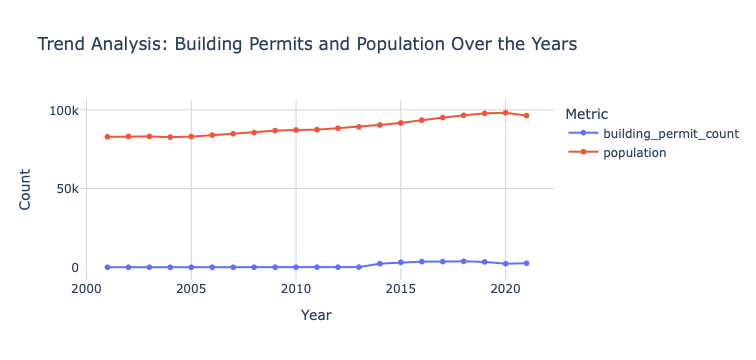

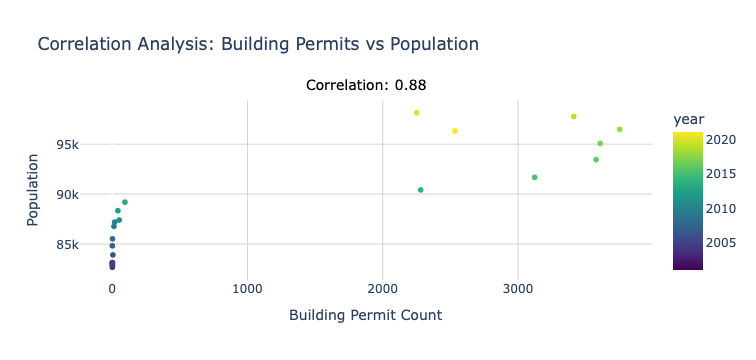

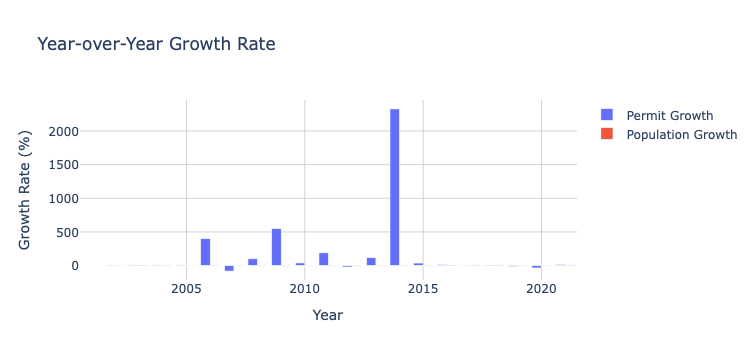

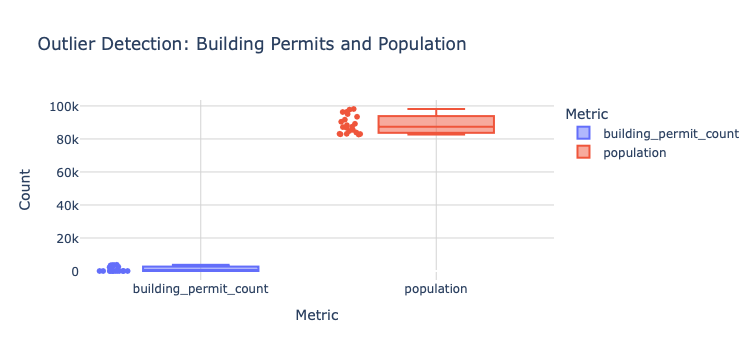

In [51]:

# Calculate year-over-year growth
analysis_df['permit_growth'] = analysis_df['building_permit_count'].pct_change() * 100
analysis_df['population_growth'] = analysis_df['population'].pct_change() * 100

# Melt the DataFrame to long format for Plotly Express
melted_df = pd.melt(analysis_df, id_vars=['year'], value_vars=['building_permit_count', 'population'],
                    var_name='Metric', value_name='Count')

# Custom colors
colors = px.colors.qualitative.Plotly

# Interactive line plot for trend analysis
fig1 = px.line(melted_df, x='year', y='Count', color='Metric', 
               title='Trend Analysis: Building Permits and Population Over the Years',
               labels={'Count': 'Count', 'year': 'Year'}, 
               markers=True,
               color_discrete_sequence=colors)
fig1.update_layout(legend_title_text='Metric', 
                   plot_bgcolor='white',
                   xaxis=dict(showgrid=True, gridcolor='lightgrey'),
                   yaxis=dict(showgrid=True, gridcolor='lightgrey'))

# Interactive scatter plot for correlation analysis
fig2 = px.scatter(analysis_df, x='building_permit_count', y='population', color='year',
                  title='Correlation Analysis: Building Permits vs Population',
                  labels={'building_permit_count': 'Building Permit Count', 'population': 'Population'},
                  hover_data={'year': True},
                  color_continuous_scale='Viridis')

# Add annotation for correlation coefficient above the plot
fig2.add_annotation(
    x=0.5, y=1.15,
    xref='paper', yref='paper',
    text=f'Correlation: {correlation:.2f}',
    showarrow=False,
    font=dict(size=14, color="black"),
    align='center',
)

fig2.update_layout(plot_bgcolor='white',
                   xaxis=dict(showgrid=True, gridcolor='lightgrey'),
                   yaxis=dict(showgrid=True, gridcolor='lightgrey'))

# Interactive bar plot for year-over-year growth
fig3 = go.Figure()
fig3.add_trace(go.Bar(x=analysis_df['year'], y=analysis_df['permit_growth'], name='Permit Growth',hovertemplate='Year: %{x}<br>Permit Growth: %{y:.2f}%<extra></extra>', marker_color=colors[0]))
fig3.add_trace(go.Bar(x=analysis_df['year'], y=analysis_df['population_growth'], name='Population Growth',hovertemplate='Year: %{x}<br>Population Growth: %{y:.2f}%<extra></extra>', marker_color=colors[1]))
fig3.update_layout(title='Year-over-Year Growth Rate',
                   xaxis_title='Year',
                   yaxis_title='Growth Rate (%)',
                   barmode='group',
                   plot_bgcolor='white',
                   xaxis=dict(showgrid=True, gridcolor='lightgrey'),
                   yaxis=dict(showgrid=True, gridcolor='lightgrey'))

# Interactive box plot for outlier detection
fig4 = px.box(melted_df, x='Metric', y='Count',
              title='Outlier Detection: Building Permits and Population',
              labels={'Count': 'Count'},
              points='all',
              color='Metric',
              color_discrete_sequence=colors)
fig4.update_layout(plot_bgcolor='white',
                   xaxis=dict(showgrid=True, gridcolor='lightgrey'),
                   yaxis=dict(showgrid=True, gridcolor='lightgrey'))

# Show plots in Jupyter Notebook
fig1.show()
fig2.show()
fig3.show()
fig4.show()